## My Kaggle submission for: Titanic - Machine Learning from Disaster
Author: Radu-Andrei Cioaca

This JupyterNotebook represents my submission to the Kaggle's Competition "Titanic - Machine Learning from Disaster" https://www.kaggle.com/competitions/titanic/. It is also my first Kaggle submission and a new and interesting Data Science project to be added to my portofolio.

This submission has scored an accuracy of 0.78468, placing it in top 15% (12 July 2023).

The problem can be read here: https://www.kaggle.com/competitions/titanic/

The data set can be inspected here: https://www.kaggle.com/competitions/titanic/data

Briefly: The dataset contains Titanic passengers described by different features (name, social class, sex, age, ticket fare, cabin, etc) and the goal of the competition is to build a model to answer the question: “what sorts of people were more likely to survive?”


## My Solution

In this notebook I performed different data understanding and preprocessing steps in order to get a feeling about the data and what can be done with it. Next, Data Exploratory Analysis is performed to select a subset of features with usage potential for a Machine Learning model. To the end, I develop a RandomForestClassifier which I tune for the highest accuracy. My thoughts, plots and code are presented below:

### 1) Data Understanding and Preparation

In [368]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('./01_data/train.csv')
df_test = pd.read_csv('./01_data/test.csv')

print("Data shape:",df.shape)
df.head()

Data shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [369]:
df.isna().sum() # checking missing data (NaN)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that we have a lot of Cabin and Age entries meetings. My idea is to focus first on the other columns and to derive as much features as possible from them with the hope that those can be later used to fill the empty spaces.

#### The "Name" column

Inspecting a bit the data for deriving new features, I see a big potential in the Name column. It contains the full name of the passenger and their Title. 

We can derive from it the following new columns

*  'FamilyName' - that could be used to group the passengers into families


*  'Title' - that could be used to get more details about the passenger (martial status, sex, age)

In [370]:
df['FamilyName'] = df['Name'].str.split(',').str[0].str.strip()
df['FirstName'] = df['Name'].str.split(',').str[1].str.strip()
df['Title'] = df['FirstName'].str.split('.').str[0].str.strip()

## Also for test data frame
df_test['FamilyName'] = df_test['Name'].str.split(',').str[0].str.strip()
df_test['FirstName'] = df_test['Name'].str.split(',').str[1].str.strip()
df_test['Title'] = df_test['FirstName'].str.split('.').str[0].str.strip()


##### The Titles of the passengers

We can see that there are many titles present it the dataset, yet only Mr, Miss, Mrs and Master are dominant, so the others can be replaced as they are not significat

<Axes: xlabel='Title'>

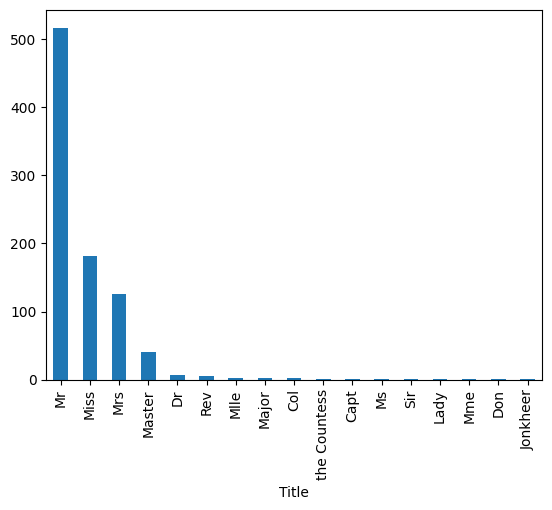

In [371]:
df['Title'].value_counts().plot.bar()

In [372]:
t_replace_dict = {'Dr':'Mr',
                  'Rev':'Mr',
                  'Mlle':'Miss',
                  'Major':'Mr',
                  'Col':'Mr',
                  'the Countess':'Mrs',
                  'Capt':'Mr',
                  'Ms':'Mrs',
                  'Sir':'Mr',
                  'Lady':'Mrs',
                  'Mme':'Mrs',
                  'Don':'Mr',
                  'Jonkheer':'Mr'}

df['Title'].replace(t_replace_dict,inplace=True)



## Also for the test data frame
df_test['Title'].replace(t_replace_dict,inplace=True)

##### Titles vs Age

It can be seen that there is a clear relationship between age and the title, Master is for children male passengers, Miss for young females and Mr and Mrs have a higher mean. This is a clear hint that we can use the titles to fill the missing age (NaN values)

<Axes: xlabel='Title', ylabel='Age'>

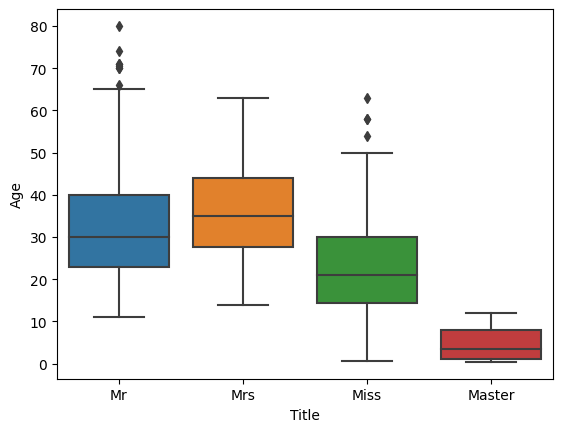

In [373]:
sns.boxplot(data=df,x='Title',y='Age')

In [374]:
average_master_age = round(df[ df.Title == 'Master']['Age'].mean()) # compute the average age for the Master Title
average_miss_age = round(df[ df.Title == 'Miss']['Age'].mean())  # compute the average age for the Miss Title
average_mr_age = round(df.loc[df['Title'] == 'Mr']['Age'].mean()) # compute the average age for the Mr Title
average_mrs_age = round(df.loc[df['Title'] == 'Mrs']['Age'].mean()) # compute the average age for the Mrs Title

#Replace the NaN Age values
df.loc[ (df.Title == 'Master') & (df.Age.isna()), 'Age' ] = average_master_age 
df.loc[ (df.Title == 'Miss') & (df.Age.isna()), 'Age' ] = average_miss_age 
df.loc[ (df['Title'] == 'Mr') & (df.Age.isna()), 'Age'] = average_mr_age
df.loc[ (df['Title'] == 'Mrs') & (df.Age.isna()), 'Age'] = average_mrs_age


## Also for the test data frame
df_test.loc[ (df_test.Title == 'Master') & (df_test.Age.isna()), 'Age' ] = average_master_age 
df_test.loc[ (df_test.Title == 'Miss') & (df_test.Age.isna()), 'Age' ] = average_miss_age 
df_test.loc[ (df_test['Title'] == 'Mr') & (df_test.Age.isna()), 'Age'] = average_mr_age
df_test.loc[ (df_test['Title'] == 'Mrs') & (df_test.Age.isna()), 'Age'] = average_mrs_age

#### "SibSp" and "Parch"

The sum of these to columns would represent the number of family members present on board for each passenger. This number might be more representative than treating them separately. (I am also aware that these columns can be exploited to find a lot of details about passenger's family)

In [375]:
df['FamilyMembers'] = df['SibSp'] + df['Parch']

## Also for the test data frame
df_test['FamilyMembers'] = df_test['SibSp'] + df_test['Parch']

#### "Embarked"

There are few missing values in the Embarked Column, which I will fill with the most frequent value

In [376]:
df.loc[df.Embarked.isna(),'Embarked'] = df['Embarked'].value_counts().sort_values(ascending=False).index[0]


#### "Cabin"

The Cabin column has a lot of missing values, but I still think it can be useful to the survival chance. I will extract just the Cabin Letter. My intuition says that based on the Cabin category or floor you could have a better survival chance.

In [377]:
df['CabinLetter'] = df['Cabin'].str[0]

## Also for the test data frame
df_test['CabinLetter'] = df_test['Cabin'].str[0]

#### "Ticket" and others

Based on internet reasearch I conclude that the Ticket no. is not relevant and has not much significance. All the ather columns are fine and I don't see how can we get more out of them for our current purpose

### 2) Data Exploratory Analysis

I ll go through each column and compare it against the "Survived" column, like this I will get hints of the most relevant features that I could later use in my model. I ll comment the code for the features with potential for the model

In [378]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyName,FirstName,Title,FamilyMembers,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris,Mr,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina,Miss,0,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs. Jacques Heath (Lily May Peel),Mrs,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr. William Henry,Mr,0,NaN


<Axes: xlabel='Pclass'>

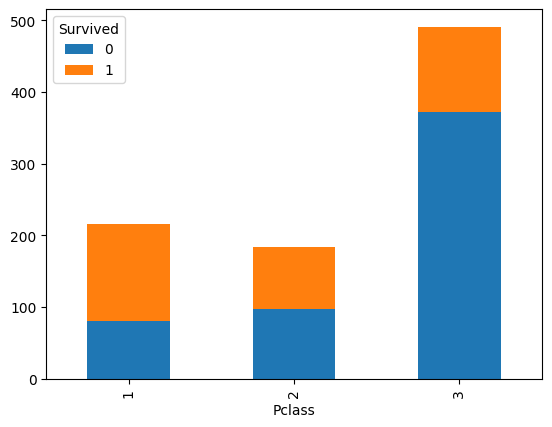

In [379]:
contingency_table = pd.crosstab(df['Pclass'], df['Survived']) #Clearly Pclass 1 had much higher chance of survival
contingency_table.plot(kind='bar', stacked=True)


<Axes: xlabel='Sex'>

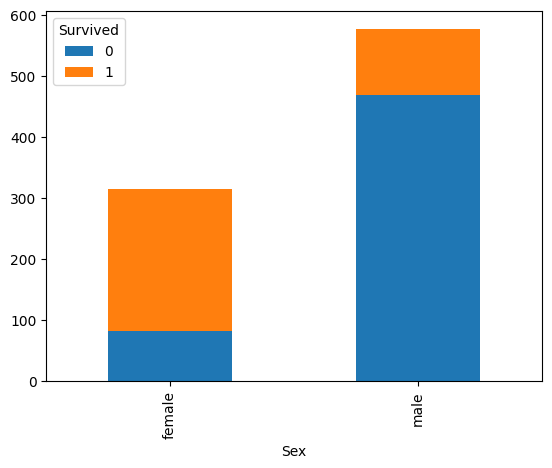

In [380]:
contingency_table = pd.crosstab(df['Sex'], df['Survived']) # it seems that females had higher survival rate so this feature is clearly useful
contingency_table.plot(kind='bar', stacked=True)


<Axes: xlabel='CabinLetter'>

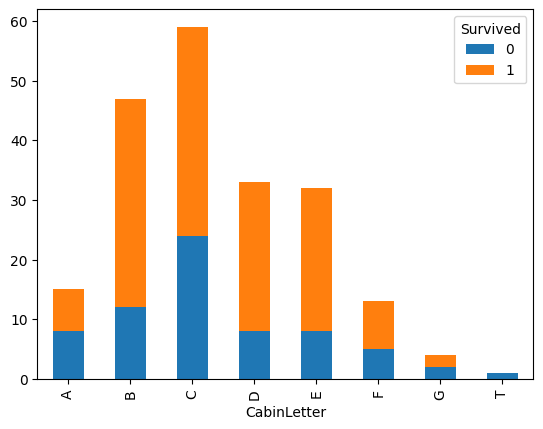

In [381]:
contingency_table = pd.crosstab(df['CabinLetter'], df['Survived']) #seems that for each letter, the survival rate is similar and this feature might not bring anything
contingency_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Embarked'>

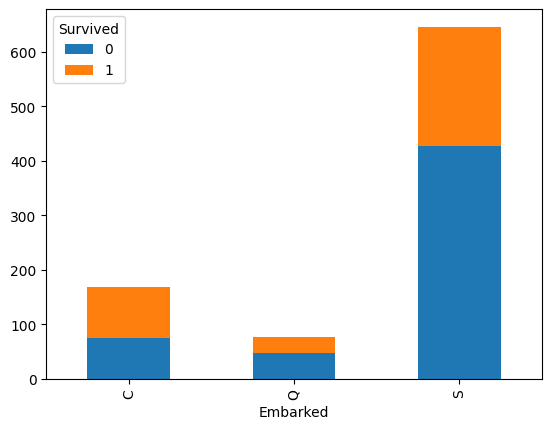

In [382]:
contingency_table = pd.crosstab(df['Embarked'], df['Survived']) # For each embarked letter there is similar survival percentage and first sight and the column is not much of use
contingency_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Survived', ylabel='Age'>

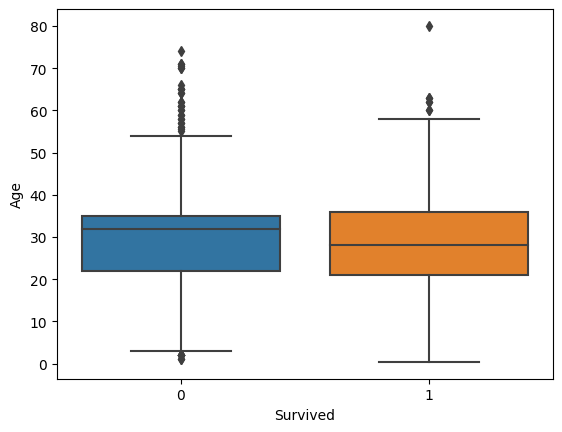

In [383]:
sns.boxplot(data=df,x='Survived',y='Age') # The median age for the surviving passengers is a bit lower showing that this feature will be useful

<Axes: xlabel='Survived', ylabel='Fare'>

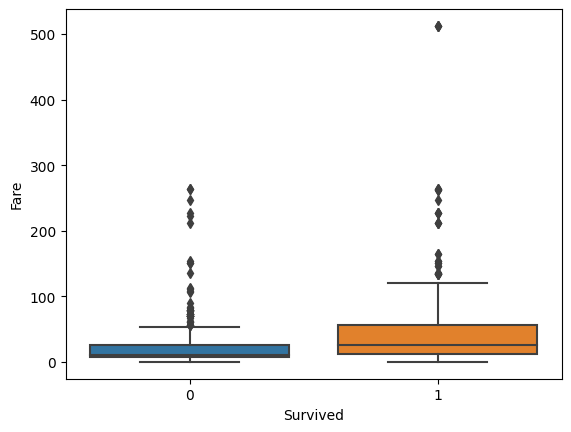

In [384]:
sns.boxplot(data=df,x='Survived',y='Fare') # the higher the fare the higher the survival, useful feature

<Axes: xlabel='Survived', ylabel='FamilyMembers'>

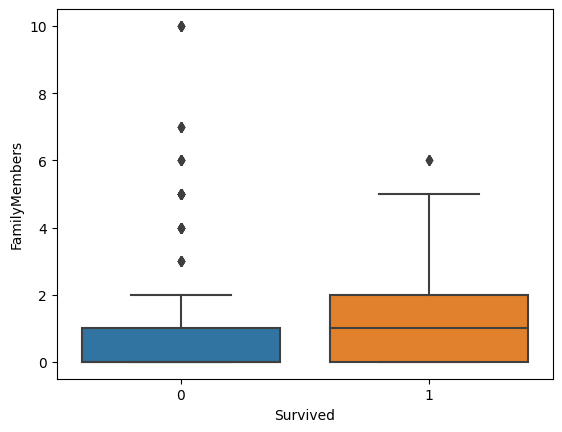

In [385]:
sns.boxplot(data=df,x='Survived',y='FamilyMembers') #the more family members, the more chances of survival

### 3) Model Development

I am planning to use a RandomForestClassifier , main driver is to study it more and I also consider it a good fit for this problem given the amount of categorical variables present in the data

In [388]:
X = df[['Pclass','Sex','Age','Fare','FamilyMembers','Embarked']] # selected features for training
Y = df['Survived'] # target variable

X = pd.get_dummies(X,columns=['Sex','Embarked'])
X.drop(columns=['Sex_male'],inplace=True) #useless because I have sex_female

#Also for the test dataframe
X_test = df_test[['Pclass','Sex','Age','Fare','FamilyMembers','Embarked']] # selected features for training

X_test = pd.get_dummies(X_test,columns=['Sex','Embarked'])
X_test.drop(columns=['Sex_male'],inplace=True) #useless because I have sex_female

In [390]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

RF = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=2)
np.mean(cross_val_score(RF,X,Y,cv=7))


0.8260774043869515

In [391]:
## try a grid search to improve the model

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10, 15]
}

model = RandomForestClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X, Y)  # X_train and y_train are your training data

# Access the results
best_params = grid_search.best_params_
best_score = grid_search.best_score_


/home/radu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/home/radu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/radu/.local/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/radu/.local/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/home/radu/.local/lib/py

In [392]:
## best params found {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}

print('best_params', best_params)
print('best_score', best_score)

RF_best = grid_search.best_estimator_



best_params {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
best_score 0.832803967108154


### 4) Prediction of the test data

In [360]:

X_test.loc[ X_test['Fare'].isna() , 'Fare'] = 7 # missing fare


Y_pred = RF_best.predict(X_test)


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [367]:
result = df_test['PassengerId'].to_frame()

result['Survived'] = Y_pred 

result.to_csv('./radu_submission_titanic2.csv',index=False)